# Urban and Rural mean LST
Code to loop through all the images for a city and return a data frame of the mean rural and urban LSTs

In [ ]:
# VI indices removed- will be calculated separately
# Optimised so the coordinate grid does not need to be created for every image

In [1]:
# Import packages
import os
import re  # regular expressions for getting lat lon grid
import pathlib
import warnings
#import gdal
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio # for extracting subsets
from rasterio.plot import plotting_extent #for plotting
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
import pandas as pd
import pickle
import matplotlib.patches as mpatches
import fnmatch  #for finding other file when city+rural isn't all in the main one (bulawayo)

#for the reprojecting
import pyproj
from pyproj import CRS
from pyproj import Transformer
import cartopy
import cartopy.crs as ccrs
from shapely.geometry import Point, LineString, Polygon
from pyhdf.SD import SD, SDC
import datetime as dt
import scipy
from scipy import interpolate
import geopandas as gpd

#Regression packages (used for linear and polynomial regression)
import operator
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

#for root finding and curve fitting
from scipy import optimize
from scipy.optimize import curve_fit

#for converting angles from radians to degrees
import math

#for computing the RMSE
from sklearn.metrics import mean_squared_error

# for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator


warnings.simplefilter('ignore')

#load in csv of city lons and lats
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','MEAN_SUHI'))

CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon_mean.xlsx')  
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon.Area_2002 >4]

In [3]:
CITY_COUNTRY_lat_lon =CITY_COUNTRY_lat_lon[48:].reset_index(drop = True)

In [4]:
CITY_COUNTRY_lat_lon

,CITY_COUNTRY,City,Lat,Lon,City_Area,City_Bound_xmin,City_Bound_xmax,City_Bound_ymin,City_Bound_ymax,koppen_climate,...,eccen_2018,major_ax_2019,minor_ax_2019,ell_theta_2019,eccen_2019,major_ax_2020,minor_ax_2020,ell_theta_2020,eccen_2020,std_dev_elevation
0,ANSHUN_CHINA,Anshun,26.244410,105.932401,32,-6000,6000,-6000,6000,Cwa,...,0.805750,3035.952726,5126.081647,1.868052,0.805750,3028.471797,5154.654348,1.841634,0.809208,96.971825
1,BOZHOU_CHINA,Bozhou,33.870279,115.776985,85,-6000,6000,-10000,6000,Cwa,...,0.634853,4236.601425,5492.607339,-0.261821,0.636438,5526.525039,4241.681978,1.323398,0.641033,9.174328
2,DAZHOU_CHINA,Dazhou,31.215920,107.500920,41,-7000,5000,-8000,5000,Cwa,...,0.719502,3654.415889,5262.013091,-0.500048,0.719502,3896.675014,5342.653560,-0.435690,0.684139,140.417969
3,DENGZHOU_CHINA,Dengzhou,32.682220,112.081940,26,-5000,4500,-4000,4000,Cwa,...,0.555950,4064.546608,3378.516320,-0.004211,0.555950,4064.546608,3378.516320,-0.004211,0.555950,20.494036
4,DEYANG_CHINA,Deyang,31.130190,104.381980,95,-9000,9000,-9000,9000,Cwa,...,0.730386,4144.912192,6068.377107,-0.332943,0.730386,4137.317000,6155.770722,-0.315650,0.740457,73.999176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,FALOOJAH_IRAQ,Faloojah,33.355810,43.786120,29,-5000,4000,-5000,5000,BWh,...,0.581405,2877.878763,3537.154813,1.264488,0.581405,2877.878763,3537.154813,1.264488,0.581405,15.111382
60,SAMARRA_IRAQ,Samarra,34.196630,43.873900,19,-4000,6000,-5000,5000,BWh,...,0.752866,2245.877799,3312.148417,2.005438,0.734995,2245.877799,3312.148417,2.005438,0.734995,16.510735
61,POLOKWANE_SOUTH_AFRICA,Polokwane,-23.904480,29.468850,96,-13000,6000,-5000,13000,BWh,...,0.829796,7758.184645,4273.557325,-0.676743,0.834608,7800.428245,4459.303408,-0.708700,0.820481,95.319702
62,BATMAN_TURKEY,Batman,37.887380,41.132210,40,-7000,5500,-5000,8000,Csa,...,0.420518,4000.069135,4408.837594,0.433952,0.420518,4000.069135,4408.837594,0.433952,0.420518,138.839844


In [2]:
CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon.CITY_COUNTRY =='ANSHUN_CHINA']

,CITY_COUNTRY,City,Lat,Lon,City_Area,City_Bound_xmin,City_Bound_xmax,City_Bound_ymin,City_Bound_ymax,koppen_climate,...,eccen_2018,major_ax_2019,minor_ax_2019,ell_theta_2019,eccen_2019,major_ax_2020,minor_ax_2020,ell_theta_2020,eccen_2020,std_dev_elevation
48,ANSHUN_CHINA,Anshun,26.24441,105.932401,32,-6000,6000,-6000,6000,Cwa,...,0.80575,3035.952726,5126.081647,1.868052,0.80575,3028.471797,5154.654348,1.841634,0.809208,96.971825


In [28]:
CITY_COUNTRY

'LONDRINA_BRAZIL'

In [5]:
##DEFINE FUNCTIONS

#Define functions for bit flag interpretation
#bit flag interpretation
#Defining QC functions
#function to check the status of a byte on the QC control
#x is the number to interrogate, n is the bit number to check
def check_bits(x,n):
    if (x & (1<<n)): 
  ## n-th bit is 1 
        flag = 1
    else:
  ## n-th bit is 0
        flag = 0
    return flag

#function to check bytes 1 and 2 and return 0 if they are both 0
def quality_control(x):
    if ((check_bits(x,1) == 0) and (check_bits(x,2) == 0)):
  ##if bit 1 and bit 2 are 0 then 0 
        flag = 0
    else:
  ##otherwise flag is 1
        flag = 1
    return flag    


#function to extract the subdatasets of interest and return a dataframe 
#QC is still needed as the pixels which are of bad quality will still need to be removed/ masked 

def dataframe_create(file_name):#, city_top):
    #Set path to chosen satellite
    #if city_top == 'Y':
    #    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, 'CITY_TOP', SATELLITE))
    #else:    
    #    os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
    #path to the file
    data_path = os.path.join(file_name)
    #LST daytime
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Day_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_day = subdataset.read(1)
                
    #LST night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Night_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_night = subdataset.read(1)                
                
                
    #QC day      
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Day*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_day = subdataset.read(1)   
                
    #QC night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Night*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_night = subdataset.read(1)   
                
                
    #Create the coordinate grid
    # Identify the data field- use the LST day but grid is same for all data
    DATAFIELD_NAME = 'LST_Day_1km'

    GRID_NAME = 'MODIS_Grid_8Day_1km_LST'
    
    #if city_top == 'Y':
        #os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, 'CITY_TOP', SATELLITE))
    #else:    
    #os.chdir(os.path.join('D:\\','MODIS_8_day_LST', CITY_COUNTRY, SATELLITE))
    
    hdf = SD(file_name, SDC.READ)

    # Read dataset.
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.float64)

    # Read global attribute.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]

    # Construct the grid.  Required information in global attribute called 'StructMetadata.0'

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = ul_regex.search(gridmeta)
    x0 = np.float(match.group('upper_left_x')) 
    y0 = np.float(match.group('upper_left_y')) 

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float(match.group('lower_right_x')) 
    y1 = np.float(match.group('lower_right_y')) 
    ny, nx = data.shape
    xinc = (x1 - x0) / nx
    yinc = (y1 - y0) / ny

    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    xv, yv = np.meshgrid(x, y)

    # convert the grid back to lat/lons.
    transformer = Transformer.from_crs("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", "EPSG:4326")
    lat, lon = transformer.transform(xv, yv)

    #Apply scale factors
    scale_factor_LST = 0.02

    LST_day = LST_day*scale_factor_LST
    LST_night = LST_night*scale_factor_LST

    #Note: fill value for LST is 0

    #Create the lists to be combined to create a dataframe
    LST_day_list = LST_day.flatten()
    LST_night_list = LST_night.flatten()
    QC_day_list = QC_day.flatten()
    QC_night_list = QC_night.flatten()
    Lon_list = lon.flatten()
    Lat_list = lat.flatten()

    #Create the dataframe

    df = pd.DataFrame(list(zip(LST_day_list, LST_night_list, QC_day_list, QC_night_list, Lon_list, Lat_list)), 
               columns =['LST_day', 'LST_night','QC_day', 'QC_night','Longitude', 'Latitude']) 
    
    #Create dataframe of the required area
    df_subset = df[(df.Latitude >= min_lat) & (df.Latitude <= max_lat) & (df.Longitude >= min_lon) & (
        df.Longitude <= max_lon)]
    df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True)
    
    return df_subset

#Define the function for the Gaussian surface
def SUHIfunc(Z,a0,x0,y0,phi,ax,ay):
    x,y = Z
    return a0 * np.exp(((-((x-x0)*np.cos(phi)+(y-y0)*np.sin(phi))**2)/(0.5*(ax**2)))
                       -((((y-y0)*np.cos(phi)-(x-x0)*np.sin(phi))**2)/(0.5*(ay**2))))

#function for transforming angle in radians to degrees
def rad_to_deg(angle):
    deg = math.degrees(angle)
    deg = deg % 360
    if deg > 180:
        deg = deg - 360
    return deg


### The below functions have been added to optimise the code - the coordinate grid is only generated once #####
### as it is the same for all the images                                                                  #####

def data_extract(file_name, Lat_list, Lon_list):#, city_top):
    #Set path to chosen satellite
    #path to the file
    data_path = os.path.join(file_name)
    #LST daytime
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Day_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_day = subdataset.read(1)
                
    #LST night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:LST_Night_1km*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    LST_night = subdataset.read(1)                
                
                
    #QC day      
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Day*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_day = subdataset.read(1)   
                
    #QC night       
    with rio.open(data_path) as dataset:
        # Loop through each subdataset in HDF4 file
        for name in dataset.subdatasets:
        
            # Use regular expression to identify if subdataset has LST:LST in the name
            if re.search("LST:QC_Night*", name):
        
                # Open the band subdataset
                with rio.open(name) as subdataset:
                    modis_meta = subdataset.profile
                
                    # Read band data as a 2 dim arr and append to list
                    QC_night = subdataset.read(1)   

                    
    #Apply scale factors
    scale_factor_LST = 0.02

    LST_day = LST_day*scale_factor_LST
    LST_night = LST_night*scale_factor_LST

    #Note: fill value for LST is 0

    #Create the lists to be combined to create a dataframe
    LST_day_list = LST_day.flatten()
    LST_night_list = LST_night.flatten()
    QC_day_list = QC_day.flatten()
    QC_night_list = QC_night.flatten()                
    
    #Create the dataframe

    df = pd.DataFrame(list(zip(LST_day_list, LST_night_list, QC_day_list, QC_night_list, Lon_list, Lat_list)), 
               columns =['LST_day', 'LST_night','QC_day', 'QC_night','Longitude', 'Latitude']) 
    
    #Create dataframe of the required area
    df_subset = df[(df.Latitude >= min_lat) & (df.Latitude <= max_lat) & (df.Longitude >= min_lon) & (
        df.Longitude <= max_lon)]
    df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True)
    
    return df_subset
    
def coord_grid_create(SATELLITE, file_name):#, city_top):          
    #Create the coordinate grid
    # Identify the data field- use the LST day but grid is same for all data
    DATAFIELD_NAME = 'LST_Day_1km'

    GRID_NAME = 'MODIS_Grid_8Day_1km_LST'
    
    hdf = SD(file_name, SDC.READ)

    # Read dataset.
    data2D = hdf.select(DATAFIELD_NAME)
    data = data2D[:,:].astype(np.float64)

    # Read global attribute.
    fattrs = hdf.attributes(full=1)
    ga = fattrs["StructMetadata.0"]
    gridmeta = ga[0]

    # Construct the grid.  Required information in global attribute called 'StructMetadata.0'

    ul_regex = re.compile(r'''UpperLeftPointMtrs=\(
                                  (?P<upper_left_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<upper_left_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = ul_regex.search(gridmeta)
    x0 = np.float(match.group('upper_left_x')) 
    y0 = np.float(match.group('upper_left_y')) 

    lr_regex = re.compile(r'''LowerRightMtrs=\(
                                  (?P<lower_right_x>[+-]?\d+\.\d+)
                                  ,
                                  (?P<lower_right_y>[+-]?\d+\.\d+)
                                  \)''', re.VERBOSE)
    match = lr_regex.search(gridmeta)
    x1 = np.float(match.group('lower_right_x')) 
    y1 = np.float(match.group('lower_right_y')) 
    ny, nx = data.shape
    xinc = (x1 - x0) / nx
    yinc = (y1 - y0) / ny

    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    xv, yv = np.meshgrid(x, y)

    # convert the grid back to lat/lons.
    transformer = Transformer.from_crs("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", "EPSG:4326")
    lat, lon = transformer.transform(xv, yv)

    #Create the lists to be combined to create a dataframe

    Lon_list = lon.flatten()
    Lat_list = lat.flatten()
    
    return Lon_list, Lat_list

#function for finding the UTM projection
def utm_zoner(lon, lat):
    utm_lon = lon+180
    utm_zone = int(np.ceil(utm_lon/6))
    south_hem =''
    if lat<0:
        south_hem = ' +south'
    proj_str = f'+proj=utm +zone={utm_zone}{south_hem}'
    return proj_str

In [ ]:
plt.style.use('default')

for count, CITY_COUNTRY in enumerate(CITY_COUNTRY_lat_lon.CITY_COUNTRY):
    SATELLITE = 'MYD11A2' #AQUA

    #Identify names/ values of chosen city
    #set the city latitude and longitudes and city name
    City_Lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lat'].values[0]
    City_Lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Lon'].values[0]
    City_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City'].values[0]
    City_area = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Area'].values[0]
    City_bound_xmin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmin'].values[0]/1000
    City_bound_xmax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_xmax'].values[0]/1000
    City_bound_ymin = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymin'].values[0]/1000
    City_bound_ymax = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['City_Bound_ymax'].values[0]/1000
    min_lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['min_lat'].values[0]
    max_lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['max_lat'].values[0]
    min_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['min_lon'].values[0]
    max_lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['max_lon'].values[0]
    Grid_Ref = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY]['Grid_Ref'].values[0]
    #city extent bound used as constraint. Used 2*sqrt(city_area) +2
    City_extent_bound = 2*np.sqrt(City_area) + 2

    #create satellite name for plots
    if SATELLITE == 'MOD11A2':
        satellite_name = 'Terra'
    else:
        satellite_name = 'Aqua'
    
    #Load in LULC data, these bases were created in JASMIN, then cropped to correct size and 5km buffer flag added
    os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
    with open('UHI_Project_Pickle_Files\LULC_Pickles\Crop_wbuffer_LULC\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
         LULC_df = pickle.load(f)
    #sort values to ensure in correct order        
    LULC_df = LULC_df.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True)   

    os.chdir(os.path.join('E:\\','City_Data','MODIS_8_day_LST',CITY_COUNTRY, SATELLITE))
    #set path to current directory
    path = pathlib.Path().absolute()

    #Read pickle files back in from image select code. These will the be looped through
    
    with open('Day_list.pkl', 'rb') as f:
        Day_list = pickle.load(f)
    
    with open('Night_list.pkl', 'rb') as f:
        Night_list = pickle.load(f)

    #Set path to chosen satellite
    os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    
    #Create the dataframe, contains the filenames and columns to be filled
    urban_rural_lst_day = pd.DataFrame(data = Day_list, columns = ['Filename'])
    urban_rural_lst_day['Date'] = np.nan
    urban_rural_lst_day['Year'] = np.nan
    urban_rural_lst_day['Month'] = np.nan
    urban_rural_lst_day['LST_URBAN'] = np.nan
    urban_rural_lst_day['LST_RURAL'] = np.nan
    
    #night 
    urban_rural_lst_night = pd.DataFrame(data = Night_list, columns = ['Filename'])
    urban_rural_lst_night['Date'] = np.nan
    urban_rural_lst_night['Year'] = np.nan
    urban_rural_lst_night['Month'] = np.nan
    urban_rural_lst_night['LST_URBAN'] = np.nan
    urban_rural_lst_night['LST_RURAL'] = np.nan
    
    #Change the coordinate reference system
    #lat and lon coordinates are not accurate as they are distorted by the shape of the map
    #create a coordinate base

    #file to create base from chosen at random, all coord grid are the same so doesn't matter
    file_name = Day_list[7]
    df_subset = dataframe_create(file_name)#, city_top = 'N')

    if CITY_COUNTRY in(["BULAWAYO_ZIMBABWE",'RIO_BRANCO_BRAZIL','SANHE_CHINA','DAYTON_USA']):
        if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
            Grid_Ref_top = 'h20v10'
        elif CITY_COUNTRY == 'RIO_BRANCO_BRAZIL':
            Grid_Ref_top = 'h11v10'  
        elif CITY_COUNTRY == 'SANHE_CHINA':
            Grid_Ref_top = 'h26v04'
        elif CITY_COUNTRY == 'DAYTON_USA':
            Grid_Ref_top = 'h11v04'
        #add in other files for cities where the rural extent goes outside of the grid box    
        #extract the julian date of the main filename
        yeardoy = file_name.split('.')[1][1:] 
        #Set path to chosen satellite
        os.chdir(os.path.join('E:\\','Grid_Refs', Grid_Ref_top, SATELLITE))
        #find the filename which contains this in the top of city files
        for file in os.listdir('.'):
            if fnmatch.fnmatch(file, '*{}*'.format(yeardoy)):
                top_file_name = file    
    
        top_file_df = dataframe_create(top_file_name)#, city_top = 'Y')
        df_subset = df_subset.append(top_file_df).reset_index(drop = True)
        df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True)
        #set path back
        os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))

    #Get the UTM of the city
    local_utm = CRS.from_proj4(utm_zoner(City_Lon, City_Lat))

    #get geometry of the subset
    df_subset_geometry = [Point(xy) for xy in zip(df_subset.Longitude, df_subset.Latitude)]

    #transform into a geopandas dataframe
    gdf = gpd.GeoDataFrame(df_subset, geometry=df_subset_geometry)
    gdf.crs= {'init': 'epsg:4326', 'no_defs': True}

    gdf2 = gdf.to_crs(epsg=local_utm.to_epsg()).copy() #create a new geo dataframe, with units in m, cartesian 2D axis 

    #origin coordinates - take to be city centre
    #create a data frame with origin points
    origin_df = pd.DataFrame(
        {'City': [CITY_COUNTRY],
         'Latitude': [City_Lat],
         'Longitude': [City_Lon]})

    origin_df_geometry = [Point(xy) for xy in zip(origin_df.Longitude, origin_df.Latitude)]

    origin_gdf = gpd.GeoDataFrame(origin_df, geometry=origin_df_geometry)

    origin_gdf.crs= {'init': 'epsg:4326', 'no_defs': True}
    origin_gdf = origin_gdf.to_crs(epsg=local_utm.to_epsg())

    #Now change the grid so the the origin is the city centre 

    #Extract the x and y coordinates 
    x_points = gdf2['geometry'].x
    y_points = gdf2['geometry'].y

    #and add the extracted coordinates to dataframe
    gdf2['xpoints'] = x_points
    gdf2['ypoints'] = y_points

    #Determine the origin (city centre)
    origin_x = origin_gdf['geometry'].x
    origin_y = origin_gdf['geometry'].y

    #Subtract the orgin from the points and convert to km
    gdf2['x_points'] = (gdf2['xpoints'] - origin_x.values) / 1000
    gdf2['y_points'] = (gdf2['ypoints'] - origin_y.values) / 1000

    #Drop the xpoints and ypoints columns as they are no longer needed
    gdf2 = gdf2.drop('xpoints', axis = 1)
    gdf2 = gdf2.drop('ypoints', axis = 1)

    #create a base of the x points and y points so don't have to generate this for every individual file, as will be the same
    x_points = gdf2.x_points.values
    y_points = gdf2.y_points.values

    #### Create the Lat and Lon lists ####
    Lon_list, Lat_list = coord_grid_create(SATELLITE, file_name)
    
    if CITY_COUNTRY in(["BULAWAYO_ZIMBABWE",'RIO_BRANCO_BRAZIL','SANHE_CHINA','DAYTON_USA']):
        if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
            Grid_Ref_top = 'h20v10'
        elif CITY_COUNTRY == 'RIO_BRANCO_BRAZIL':
            Grid_Ref_top = 'h11v10'  
        elif CITY_COUNTRY == 'SANHE_CHINA':
            Grid_Ref_top = 'h26v04'
        elif CITY_COUNTRY == 'DAYTON_USA':
            Grid_Ref_top = 'h11v04'
        #add in other files for cities where the rural extent goes outside of the grid box    
        #extract the julian date of the main filename
        yeardoy = file_name.split('.')[1][1:] 
        #Set path to chosen satellite
        os.chdir(os.path.join('E:\\','Grid_Refs', Grid_Ref_top, SATELLITE))
        #find the filename which contains this in the top of city files
        for file in os.listdir('.'):
            if fnmatch.fnmatch(file, '*{}*'.format(yeardoy)):
                top_file_name = file    
    
        Lon_list_top, Lat_list_top = coord_grid_create(SATELLITE, top_file_name)
        #set path back
        os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    
    #loop through the QC list and calculate the parameters
    #Runtime: 45 mins

    for i in range(len(Day_list)):
        os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE)) #make sure correct filepath
        file_name = Day_list[i]

        df_subset = data_extract(file_name, Lat_list, Lon_list )
        #add in other files for cities where the rural extent goes outside of the grid box    
    
        if CITY_COUNTRY in(["BULAWAYO_ZIMBABWE",'RIO_BRANCO_BRAZIL','SANHE_CHINA','DAYTON_USA']):
            if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
                Grid_Ref_top = 'h20v10'
            elif CITY_COUNTRY == 'RIO_BRANCO_BRAZIL':
                Grid_Ref_top = 'h11v10'  
            elif CITY_COUNTRY == 'SANHE_CHINA':
                Grid_Ref_top = 'h26v04'
            elif CITY_COUNTRY == 'DAYTON_USA':
                Grid_Ref_top = 'h11v04'
            #add in other files for cities where the rural extent goes outside of the grid box   
            #Set path to chosen satellite
            os.chdir(os.path.join('E:\\','Grid_Refs', Grid_Ref_top, SATELLITE))
    
            #extract the julian date of the main filename
            yeardoy = file_name.split('.')[1][1:] 

            #find the filename which contains this in the top of city files
            for file in os.listdir('.'):
                if fnmatch.fnmatch(file, '*{}*'.format(yeardoy)):
                    top_file_name = file    
    
            top_file_df = data_extract(top_file_name, Lat_list_top, Lon_list_top)
            
            df_subset = df_subset.append(top_file_df).reset_index(drop = True)
            df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True) 
            #set path back
            os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    
        yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
        date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
        year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 
        month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m') 

        #add in the x y coords
        df_subset['x_points'] = x_points
        df_subset['y_points'] = y_points

        #add a translated QC flag (where 0 is usuable, 1 not usable) 
        #apply QC function to dataframe (function checks that the first 2 bytes of the QC flag are 0, which means its good quality)
        QC_day2 = np.array([quality_control(int(i)) for i in df_subset.QC_day])

        #add this QC2 flag onto the dataset
        df_subset['QC_day2'] = QC_day2
        
        #add in the urban classification
        #going to remove 2021 anyway so doesn't matter its not accurate
        if year in ('2021','2022'):
            year2 = '2020'
        else:
            year2 = year
        #add in urban classification to check for urban land    
        df_subset['is_urban'] = LULC_df['is_urban_overall_{}'.format(year2)].values
    
        #add in lccs classification 2015 to check for waterbodies 
        df_subset['lccs_class_overall_2015'] = LULC_df['lccs_class_overall_2015'].values
    
        #outside of city area and urban
        df_drop = df_subset[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
                             | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
                      ) & (df_subset['is_urban'] == 1)]

        #remove the areas which are urban but outside the city from the analysis
        df_subset = df_subset.drop(df_drop.index)
    
        #remove water bodies 
        df_drop = df_subset[(df_subset['lccs_class_overall_2015'] == 210)]
        df_subset = df_subset.drop(df_drop.index)
    
        #the urban classification and QC2 flag used to apply mask to the urban areas and the areas with QC2 flag = 1
        #remove the pixels which are not of good quality from the dataset
        df_day_gq = df_subset[df_subset['QC_day2'] == 0].copy()

        #take out the urban pixels and apply the linear regression

        #Extract rural df for the daytime and nighttime images
        df_rural_day = df_day_gq[df_day_gq['is_urban'] == 0][['LST_day','x_points', 'y_points']].copy()
            
        #calculate mean LSTs
        LST_URBAN = df_day_gq[df_day_gq['is_urban'] == 1]['LST_day'].mean() 
        LST_RURAL = df_day_gq[df_day_gq['is_urban'] == 0]['LST_day'].mean()
    
        # fill the dfs 
        urban_rural_lst_day['Date'][i] = date
        urban_rural_lst_day['Year'][i] = year
        urban_rural_lst_day['Month'][i] = month
        urban_rural_lst_day['LST_URBAN'][i] = LST_URBAN
        urban_rural_lst_day['LST_RURAL'][i] = LST_RURAL

    #where to save df
    os.chdir(os.path.join('E:\\','City_Data','MODIS_8_day_LST',CITY_COUNTRY, SATELLITE))
    #save the dataframe as a pickle
    pickle_name = 'urban_rural_lst_day_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(urban_rural_lst_day, f)
    
    #NIGHT
    #loop through the QC list and calculate the parameters
    os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    for i in range(len(Night_list)):

        file_name = Night_list[i]

        df_subset = data_extract(file_name, Lat_list, Lon_list)

        if CITY_COUNTRY in(["BULAWAYO_ZIMBABWE",'RIO_BRANCO_BRAZIL','SANHE_CHINA', 'DAYTON_USA']):
            if CITY_COUNTRY == "BULAWAYO_ZIMBABWE":
                Grid_Ref_top = 'h20v10'
            elif CITY_COUNTRY == 'RIO_BRANCO_BRAZIL':
                Grid_Ref_top = 'h11v10'  
            elif CITY_COUNTRY == 'SANHE_CHINA':
                Grid_Ref_top = 'h26v04'
            elif CITY_COUNTRY == 'DAYTON_USA':
                Grid_Ref_top = 'h11v04'
            #add in other files for cities where the rural extent goes outside of the grid box   
            #Set path to chosen satellite
            os.chdir(os.path.join('E:\\','Grid_Refs', Grid_Ref_top, SATELLITE))
    
            #extract the julian date of the main filename
            yeardoy = file_name.split('.')[1][1:] 

            #find the filename which contains this in the top of city files
            for file in os.listdir('.'):
                if fnmatch.fnmatch(file, '*{}*'.format(yeardoy)):
                    top_file_name = file    
    
            top_file_df = data_extract(top_file_name, Lat_list_top, Lon_list_top)
            
            df_subset = df_subset.append(top_file_df).reset_index(drop = True)
            df_subset = df_subset.sort_values(by=['Latitude', 'Longitude']).reset_index(drop = True) 
            #set path back
            os.chdir(os.path.join('E:\\','Grid_Refs',Grid_Ref, SATELLITE))
    
        yeardoy = file_name.split('.')[1][1:]                               # Split filename to retrieve acquisition date
        date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y') 
        year = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%Y') 
        month = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%m') 

        #add in the x y coords
        df_subset['x_points'] = x_points
        df_subset['y_points'] = y_points

        #add a translated QC flag (where 0 is usuable, 1 not usable) 
        #apply QC function to dataframe (function checks that the first 2 bytes of the QC flag are 0, which means its good quality)   
        QC_night2 = np.array([quality_control(int(i)) for i in df_subset.QC_night])

        #add this QC2 flag onto the dataset
        df_subset['QC_night2'] = QC_night2

        #add in the urban classification      
        #going to remove 2021 anyway so doesn't matter its not accurate
        if year in ('2021'):
            year2 = '2020'
        elif year in ('2022'):
            year2 = '2020'
        else:
            year2 = year
        #add in urban classification to check for urban land    
        df_subset['is_urban'] = LULC_df['is_urban_overall_{}'.format(year2)].values
    
        #add in lccs classification 2015 to check for waterbodies
        df_subset['lccs_class_overall_2015'] = LULC_df['lccs_class_overall_2015'].values
    
        #outside of city area and urban
        df_drop = df_subset[((df_subset['x_points'] < City_bound_xmin) | (df_subset['x_points'] > City_bound_xmax) 
                             | (df_subset['y_points'] < City_bound_ymin) | (df_subset['y_points'] > City_bound_ymax)
              ) & (df_subset['is_urban'] == 1)]

        #remove the areas which are urban but outside the city from the analysis
        df_subset = df_subset.drop(df_drop.index)
    
        #remove water bodies 
        df_drop = df_subset[(df_subset['lccs_class_overall_2015'] == 210)]
        df_subset = df_subset.drop(df_drop.index)
    
        #the urban classification and QC2 flag used to apply mask to the urban areas and the areas with QC2 flag = 1
        #remove the pixels which are not of good quality from the dataset
        #Separates into daytime good quality pixels and nightime good quality pixels 
        df_night_gq = df_subset[df_subset['QC_night2'] == 0].copy()

        #take out the urban pixels and apply the linear regression

        #Extract rural df for the daytime and nighttime images
        df_rural_night = df_night_gq[df_night_gq['is_urban'] == 0][['LST_night','x_points', 'y_points']].copy()

        # Find mean LSTs
        LST_URBAN = df_night_gq[df_night_gq['is_urban'] == 1]['LST_night'].mean()
        LST_RURAL = df_night_gq[df_night_gq['is_urban'] == 0]['LST_night'].mean()
        
        # fill the dfs 
        urban_rural_lst_night['Date'][i] = date
        urban_rural_lst_night['Year'][i] = year
        urban_rural_lst_night['Month'][i] = month
        urban_rural_lst_night['LST_URBAN'][i] = LST_URBAN
        urban_rural_lst_night['LST_RURAL'][i] = LST_RURAL

    #where to save df
    os.chdir(os.path.join('E:\\','City_Data','MODIS_8_day_LST',CITY_COUNTRY, SATELLITE))
    #save the dataframe as a pickle
    pickle_name = 'urban_rural_lst_night_{}_{}.pkl'.format(CITY_COUNTRY, SATELLITE)
    with open(pickle_name, 'wb') as f:
        pickle.dump(urban_rural_lst_night, f)
    
    ##########################################################
    #################### CREATE PLOTS ########################
    ##########################################################
    #Create graphs of the parameters and save them 

    #DAYTIME and NIGHTIME

    #set year span as different for terra and aqua
    if satellite_name == 'Terra':
        year_span = range(2000,2021)
    else:
        year_span = range(2002,2021)
    
    #create monthly and annual averages
    g_mon = urban_rural_lst_day.groupby(["Month"])
    monthly_averages = g_mon.aggregate({"LST_URBAN":np.mean, "LST_RURAL":np.mean}).reset_index()

    monthly_std_dev= g_mon.aggregate({"LST_URBAN":np.std, "LST_RURAL":np.std}).reset_index()

    g_yr = urban_rural_lst_day.groupby(["Year"])
    yearly_averages = g_yr.aggregate({"LST_URBAN":np.mean, "LST_RURAL":np.mean}).reset_index()

    yearly_std_dev= g_yr.aggregate({"LST_URBAN":np.std, "LST_RURAL":np.std}).reset_index()

    #remove 2021 from yearly averages as year is not complete
    yearly_averages = (yearly_averages[yearly_averages['Year'] != '2021']).copy()
    yearly_std_dev = (yearly_std_dev[yearly_std_dev['Year'] != '2021']).copy()
    yearly_averages = (yearly_averages[yearly_averages['Year'] != '2022']).copy()
    yearly_std_dev = (yearly_std_dev[yearly_std_dev['Year'] != '2022']).copy()
    
    #save a monthly/ annual day table 

    #check for months which have no data so are not in the table
    all_months = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if len(monthly_averages) != 12:
        # find which is the missing month and add it into the df with nan values
        missing_month = [i for i in all_months if i not in monthly_averages.Month.values]
        new_row = missing_month + [np.nan,np.nan]
        monthly_averages.loc[len(monthly_averages)] = new_row
        monthly_averages.sort_values(by = 'Month')
        monthly_std_dev.loc[len(monthly_std_dev)] = new_row
        monthly_std_dev.sort_values(by = 'Month')
        
    #create monthly and annual averages, nightime
    night_g_mon = urban_rural_lst_night.groupby(["Month"])
    night_monthly_averages = night_g_mon.aggregate({"LST_URBAN":np.mean, "LST_RURAL":np.mean}).reset_index()

    night_monthly_std_dev= night_g_mon.aggregate({"LST_URBAN":np.std, "LST_RURAL":np.std}).reset_index()

    night_g_yr = urban_rural_lst_night.groupby(["Year"])
    night_yearly_averages = night_g_yr.aggregate({"LST_URBAN":np.mean, "LST_RURAL":np.mean}).reset_index()

    night_yearly_std_dev= night_g_yr.aggregate({"LST_URBAN":np.std, "LST_RURAL":np.std}).reset_index()

    #remove 2021/ 2022 from yearly averages as year is not complete
    night_yearly_averages = (night_yearly_averages[night_yearly_averages['Year'] != '2021']).copy()
    night_yearly_std_dev = (night_yearly_std_dev[night_yearly_std_dev['Year'] != '2021']).copy()
    
    night_yearly_averages = (night_yearly_averages[night_yearly_averages['Year'] != '2022']).copy()
    night_yearly_std_dev = (night_yearly_std_dev[night_yearly_std_dev['Year'] != '2022']).copy()
    
    #check for months which have no data so are not in the table
    if len(night_monthly_averages) != 12:
        # find which is the missing month and add it into the df with nan values
        missing_month = [i for i in all_months if i not in night_monthly_averages.Month.values]
        new_row = missing_month + [np.nan,np.nan]
        night_monthly_averages.loc[len(night_monthly_averages)] = new_row
        night_monthly_averages.sort_values(by = 'Month')
        night_monthly_std_dev.loc[len(night_monthly_std_dev)] = new_row
        night_monthly_std_dev.sort_values(by = 'Month')
    
    fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(20, 15))

    if satellite_name == 'Terra':
        day_label = 'Day (10:30am)'
        night_label = 'Night (10:30pm)'
    else:
        day_label = 'Day (1:30pm)'
        night_label = 'Night (1.30am)'

    axes[0,0].errorbar(x = range(1,13), y = monthly_averages.LST_URBAN -273.15, yerr = monthly_std_dev.LST_URBAN,
                      label = 'Urban LST')
    
    axes[0,0].errorbar(x = range(1,13), y = monthly_averages.LST_RURAL -273.15, yerr = monthly_std_dev.LST_RURAL,
                      label = 'Rural LST')
    
    axes[0,0].set_title('{} Monthly Mean LST 13:30'.format(City_name))
    axes[0,0].set(xlabel = 'Month', ylabel = 'LST ($^\circ$C)')
    axes[0,0].legend()

    axes[0,1].errorbar(x = range(1,13), y = night_monthly_averages.LST_URBAN -273.15, yerr = night_monthly_std_dev.LST_URBAN,
                      label = 'Urban LST')
    
    axes[0,1].errorbar(x = range(1,13), y = night_monthly_averages.LST_RURAL -273.15, yerr = night_monthly_std_dev.LST_RURAL,
                      label = 'Rural LST')
    
    axes[0,1].set_title('{} Monthly Mean LST 01:30'.format(City_name))
    axes[0,1].set(xlabel = 'Month', ylabel = 'LST ($^\circ$C)')
    axes[0,1].legend()
    
    axes[1,0].errorbar(x = year_span, y = yearly_averages.LST_URBAN-273.15, yerr = yearly_std_dev.LST_URBAN, 
                       label = 'Urban LST')
    axes[1,0].errorbar(x = year_span, y = yearly_averages.LST_RURAL-273.15, yerr = yearly_std_dev.LST_RURAL, 
                       label = 'Rural LST')
    
    axes[1,0].set_title('{} Annual Mean LST 13:30'.format(City_name))
    axes[1,0].set(xlabel = 'Year', ylabel = 'LST ($^\circ$C)')
    axes[1,0].legend()
    
    axes[1,1].errorbar(x = year_span, y = night_yearly_averages.LST_URBAN-273.15, yerr = night_yearly_std_dev.LST_URBAN, 
                       label = 'Urban LST')
    axes[1,1].errorbar(x = year_span, y = night_yearly_averages.LST_RURAL-273.15, yerr = night_yearly_std_dev.LST_RURAL, 
                       label = 'Rural LST')
    
    axes[1,1].set_title('{} Annual Mean LST 01:30'.format(City_name))
    axes[1,1].set(xlabel = 'Year', ylabel = 'LST ($^\circ$C)')
    axes[1,1].legend()
    
    xa = axes[1,0].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    xa = axes[1,1].get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    
    #save the plot as a png
    plt.savefig('URBAN_RURAL_LST.png'.format(City_name, satellite_name))
    plt.close()


In [35]:
CITY_COUNTRY

'ANSHUN_CHINA'

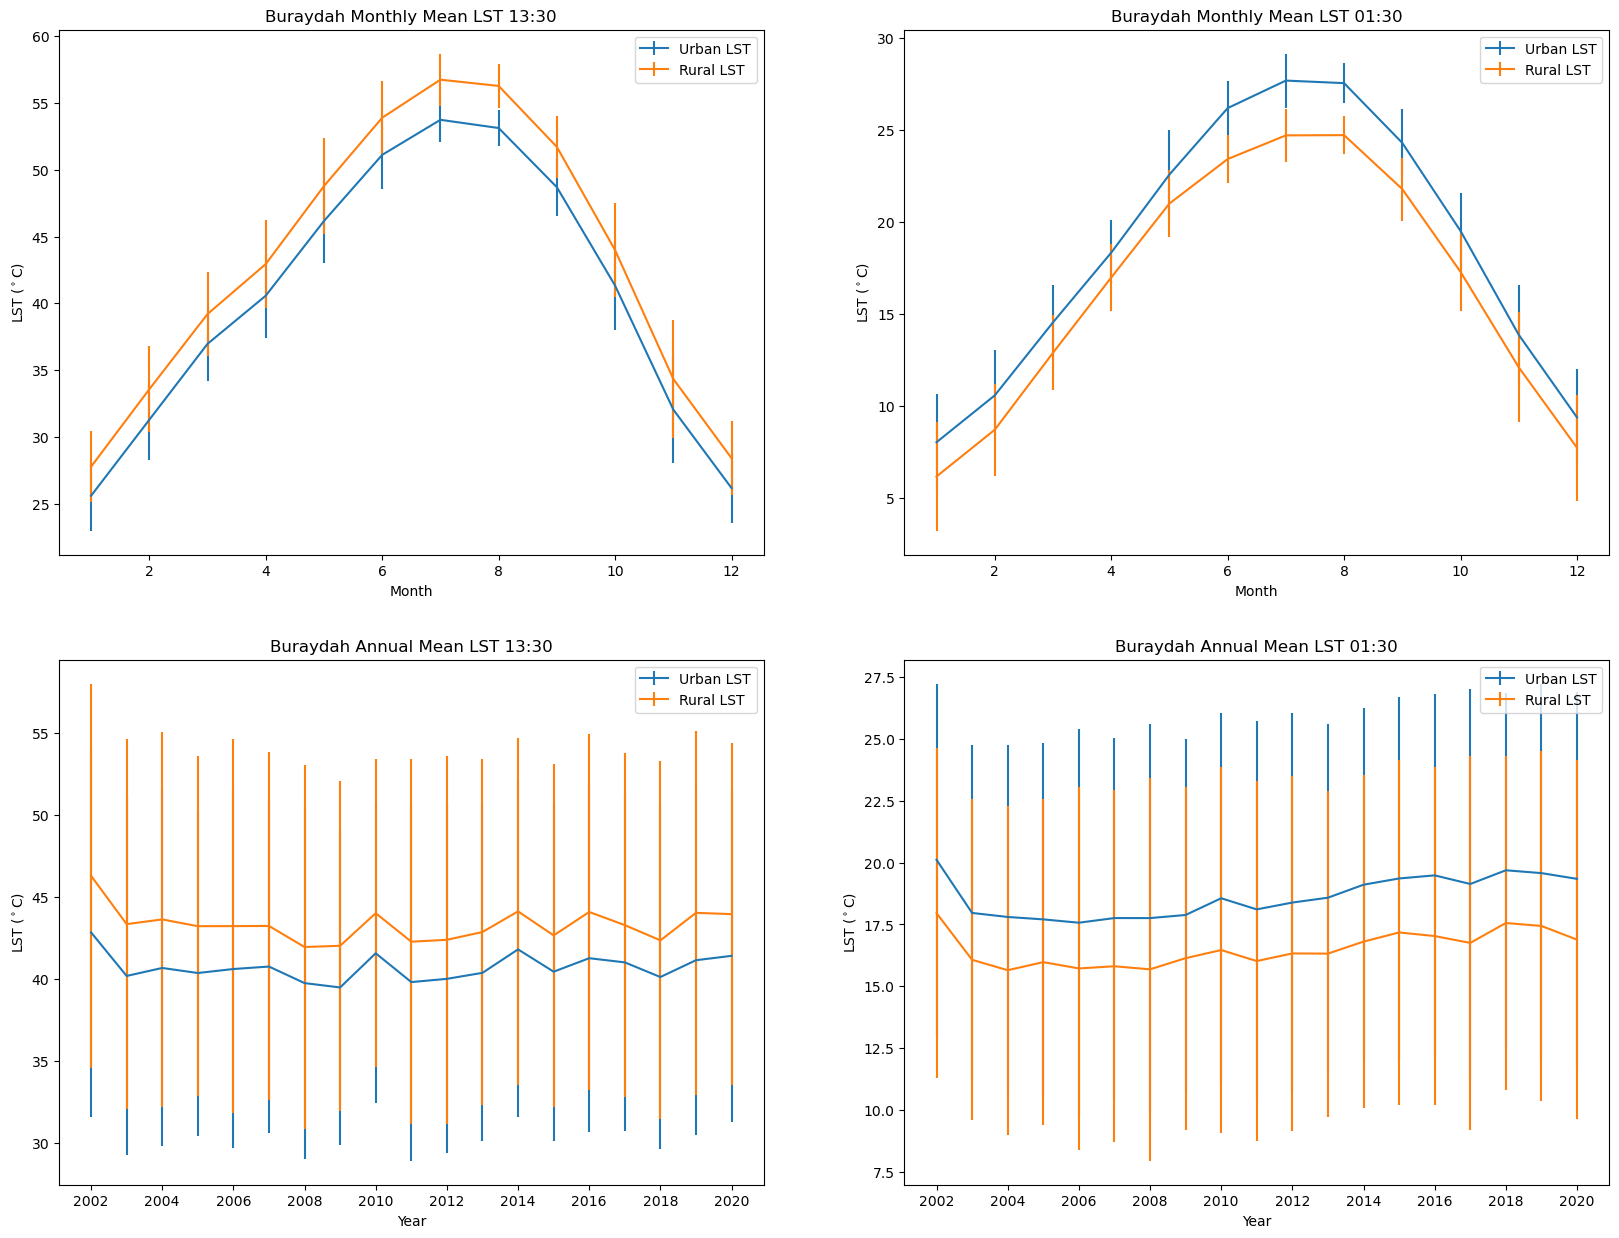

In [6]:
if satellite_name == 'Terra':
    year_span = range(2000,2021)
else:
    year_span = range(2002,2021)
    
#create monthly and annual averages
g_mon = urban_rural_lst_day.groupby(["Month"])
monthly_averages = g_mon.aggregate({"LST_URBAN":np.mean, "LST_RURAL":np.mean}).reset_index()

monthly_std_dev= g_mon.aggregate({"LST_URBAN":np.std, "LST_RURAL":np.std}).reset_index()

g_yr = urban_rural_lst_day.groupby(["Year"])
yearly_averages = g_yr.aggregate({"LST_URBAN":np.mean, "LST_RURAL":np.mean}).reset_index()

yearly_std_dev= g_yr.aggregate({"LST_URBAN":np.std, "LST_RURAL":np.std}).reset_index()

#remove 2021 from yearly averages as year is not complete
yearly_averages = (yearly_averages[yearly_averages['Year'] != '2021']).copy()
yearly_std_dev = (yearly_std_dev[yearly_std_dev['Year'] != '2021']).copy()
yearly_averages = (yearly_averages[yearly_averages['Year'] != '2022']).copy()
yearly_std_dev = (yearly_std_dev[yearly_std_dev['Year'] != '2022']).copy()
    
    #save a monthly/ annual day table 

    #check for months which have no data so are not in the table
all_months = ['01','02','03','04','05','06','07','08','09','10','11','12']
if len(monthly_averages) != 12:
    # find which is the missing month and add it into the df with nan values
    missing_month = [i for i in all_months if i not in monthly_averages.Month.values]
    new_row = missing_month + [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
    monthly_averages.loc[len(monthly_averages)] = new_row
    monthly_averages.sort_values(by = 'Month')
    monthly_std_dev.loc[len(monthly_std_dev)] = new_row
    monthly_std_dev.sort_values(by = 'Month')
        
    
    
#create monthly and annual averages, nightime
night_g_mon = urban_rural_lst_night.groupby(["Month"])
night_monthly_averages = night_g_mon.aggregate({"LST_URBAN":np.mean, "LST_RURAL":np.mean}).reset_index()

night_monthly_std_dev= night_g_mon.aggregate({"LST_URBAN":np.std, "LST_RURAL":np.std}).reset_index()

night_g_yr = urban_rural_lst_night.groupby(["Year"])
night_yearly_averages = night_g_yr.aggregate({"LST_URBAN":np.mean, "LST_RURAL":np.mean}).reset_index()

night_yearly_std_dev= night_g_yr.aggregate({"LST_URBAN":np.std, "LST_RURAL":np.std}).reset_index()

#remove 2021/ 2022 from yearly averages as year is not complete
night_yearly_averages = (night_yearly_averages[night_yearly_averages['Year'] != '2021']).copy()
night_yearly_std_dev = (night_yearly_std_dev[night_yearly_std_dev['Year'] != '2021']).copy()
    
night_yearly_averages = (night_yearly_averages[night_yearly_averages['Year'] != '2022']).copy()
night_yearly_std_dev = (night_yearly_std_dev[night_yearly_std_dev['Year'] != '2022']).copy()
    
    #check for months which have no data so are not in the table
if len(night_monthly_averages) != 12:
    # find which is the missing month and add it into the df with nan values
    missing_month = [i for i in all_months if i not in night_monthly_averages.Month.values]
    new_row = missing_month + [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
    night_monthly_averages.loc[len(night_monthly_averages)] = new_row
    night_monthly_averages.sort_values(by = 'Month')
    night_monthly_std_dev.loc[len(night_monthly_std_dev)] = new_row
    night_monthly_std_dev.sort_values(by = 'Month')
    
fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize=(20, 15))

if satellite_name == 'Terra':
    day_label = 'Day (10:30am)'
    night_label = 'Night (10:30pm)'
else:
    day_label = 'Day (1:30pm)'
    night_label = 'Night (1.30am)'

axes[0,0].errorbar(x = range(1,13), y = monthly_averages.LST_URBAN -273.15, yerr = monthly_std_dev.LST_URBAN,
                      label = 'Urban LST')
    
axes[0,0].errorbar(x = range(1,13), y = monthly_averages.LST_RURAL -273.15, yerr = monthly_std_dev.LST_RURAL,
                      label = 'Rural LST')
    
axes[0,0].set_title('{} Monthly Mean LST 13:30'.format(City_name))
axes[0,0].set(xlabel = 'Month', ylabel = 'LST ($^\circ$C)')
axes[0,0].legend()

axes[0,1].errorbar(x = range(1,13), y = night_monthly_averages.LST_URBAN -273.15, yerr = night_monthly_std_dev.LST_URBAN,
                  label = 'Urban LST')
    
axes[0,1].errorbar(x = range(1,13), y = night_monthly_averages.LST_RURAL -273.15, yerr = night_monthly_std_dev.LST_RURAL,
                      label = 'Rural LST')
    
axes[0,1].set_title('{} Monthly Mean LST 01:30'.format(City_name))
axes[0,1].set(xlabel = 'Month', ylabel = 'LST ($^\circ$C)')
axes[0,1].legend()
    
axes[1,0].errorbar(x = year_span, y = yearly_averages.LST_URBAN-273.15, yerr = yearly_std_dev.LST_URBAN, 
                       label = 'Urban LST')
axes[1,0].errorbar(x = year_span, y = yearly_averages.LST_RURAL-273.15, yerr = yearly_std_dev.LST_RURAL, 
                       label = 'Rural LST')
    
axes[1,0].set_title('{} Annual Mean LST 13:30'.format(City_name))
axes[1,0].set(xlabel = 'Year', ylabel = 'LST ($^\circ$C)')
axes[1,0].legend()
    
axes[1,1].errorbar(x = year_span, y = night_yearly_averages.LST_URBAN-273.15, yerr = night_yearly_std_dev.LST_URBAN, 
                       label = 'Urban LST')
axes[1,1].errorbar(x = year_span, y = night_yearly_averages.LST_RURAL-273.15, yerr = night_yearly_std_dev.LST_RURAL, 
                       label = 'Rural LST')
    
axes[1,1].set_title('{} Annual Mean LST 01:30'.format(City_name))
axes[1,1].set(xlabel = 'Year', ylabel = 'LST ($^\circ$C)')
axes[1,1].legend()
    
xa = axes[1,0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
xa = axes[1,1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True)) #make sure the y axis sticks to integers as is by year
    
#save the plot as a png
plt.savefig('URBAN_RURAL_LST.png'.format(City_name, satellite_name))
#plt.close()
